# Time series ML model

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import random
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle as pk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from IPython.display import clear_output

## Load dataset

In [17]:
#https://www.kaggle.com/datasets/sagnikseal/household-power-consumption
full_data = pd.read_csv('dataset.csv').rename(columns={'Global_active_power':'label'})

In [93]:
full_data.head()

,label,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,timestamp
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [85]:
df_ML = full_data[~full_data['timestamp'].str.startswith('2010')].drop('timestamp',axis=1)
df_validation = full_data[full_data['timestamp'].str.startswith('2010')]
print(df_ML.shape)
print(df_validation.shape)

(1591886, 7)
(457394, 8)


## Check correlations

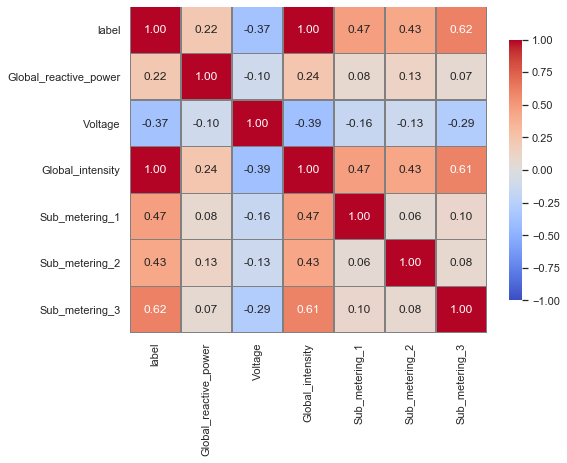

In [106]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    df_ML.sample(2000).corr(), 
    cmap='coolwarm', 
    linewidths=.2,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    vmax=1,
    vmin=-1,
    fmt='.2f'
)

In that case, the label is correlated with Global_intensity so machine learning is useless... However, as this notebook is a cookbook, we do it anyway :)

## Prepare training / testing set

In [24]:
features_col = df_ML.drop('label',axis=1).columns
label_col = 'label'

In [94]:
features_col

Index(['Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'],
      dtype='object')

In [25]:
X = np.array(df_ML[features_col])
y = np.array(df_ML.label)
print(X.shape)
print(y.shape)

(1591886, 6)
(1591886,)


In [26]:
def split_ks_similarity(X, y, test_size, target_p_feat, target_p_label):
    '''
    Make train/test split with a KS test for datasets distribution similarity
    https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    '''
    # similarity min score for feature i and label init
    min_feat_score = 0
    label_score = 0
    count = 0
    
    while (min_feat_score < target_p_feat) or (label_score < target_p_label):
        
        clear_output(wait=True)
        
        feat_scores = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        for i in range(X.shape[1]):
            feat_scores.append(stats.ks_2samp(X_train[:, i], X_test[:, i]).pvalue)
        
        min_feat_score = min(feat_scores)
        label_score = stats.ks_2samp(y_train, y_test).pvalue
        
        count += 1
        print('iteration',count)
    
    # print final stats
    print('features p-values = {}'.format([round(x,2) for x in feat_scores]))
    print('label p-values = {:.2f}'.format(label_score))
    print('X_train shape',X_train.shape)
    print('y_train shape',y_train.shape)
    print('X_test shape',X_test.shape)
    print('y_test shape',y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [28]:
X_train, X_test, y_train, y_test = split_ks_similarity(X, y, test_size=0.2, target_p_feat=0.5, target_p_label=0.7)

iteration 2
features p-values = [0.99, 0.76, 0.91, 1.0, 1.0, 1.0]
label p-values = 0.90
X_train shape (1273508, 6)
y_train shape (1273508,)
X_test shape (318378, 6)
y_test shape (318378,)


Text(0.5, 1.0, 'Distribution: label')

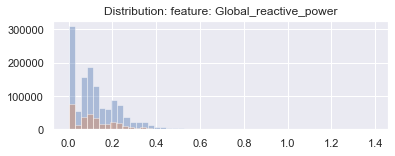

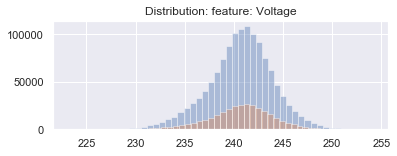

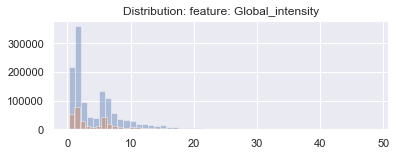

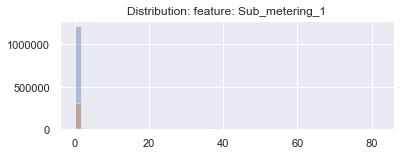

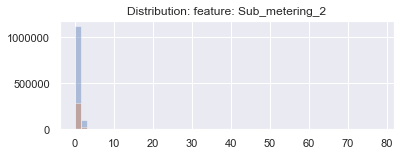

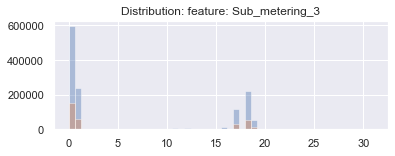

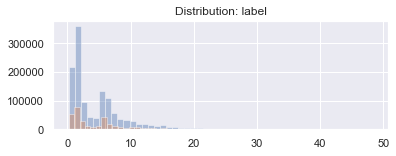

In [32]:
# plot distribution of parameters (check representativeness)
for i,col in zip(range(X.shape[1]),features_col):
    fig,ax = plt.subplots(figsize=(6,2))
    sns.distplot(X_train[:, i],label='train',kde=False)
    sns.distplot(X_test[:, i],label='test',kde=False)
    plt.title('Distribution: feature: {}'.format(col))
    
fig,ax = plt.subplots(figsize=(6,2))
sns.distplot(X_train[:, 2],label='train',kde=False)
sns.distplot(X_test[:, 2],label='test',kde=False)
plt.title('Distribution: label')

## Train model

In [34]:
# cross-validator : ShuffleSplit 
ss = ShuffleSplit(n_splits = 5, test_size = 0.1)

# Functions to be used in the pipeline
skb = SelectKBest(f_regression)

### Import regressor ###
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
reg = BaggingRegressor()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ("SKB",skb),
    ("REG",reg)
])   

# parameters to tune 
param_grid = {
    "SKB__k":["all"],
    "REG__base_estimator":[DecisionTreeRegressor()],
    "REG__n_estimators":[10],
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = ss)

In [35]:
%%time
# training regressor
print(" > training regressor:")
grid.fit(X_train, y_train.ravel())

# best regressor using the cross-validator and the Shuffle Split 
reg = grid.best_estimator_

# predicition with the classifier
y_pred = reg.predict(X_test)

# print grid parameters
print("\n > Best grid search:")
print(grid.best_params_)

# print metrics
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
print('\nRMSE = {:.2f}\nr2 = {:.3f}\n'.format(RMSE,R2))

 > training regressor:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.8min finished



 > Best grid search:
{'REG__base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), 'REG__n_estimators': 10, 'SKB__k': 'all'}

RMSE = 0.03
r2 = 0.999

Wall time: 8min 27s


In [37]:
# Feature importance
df_imp = pd.DataFrame({
    'feature':df_ML[features_col].columns.to_list(),
    'score':grid.best_estimator_.named_steps['SKB'].scores_
}).sort_values('score',ascending=False)
df_imp['pct'] = (df_imp['score']/df_imp['score'].sum()*100).apply(lambda x: '{:.2f}%'.format(x))
df_imp[['feature','pct']]

,feature,pct
2,Global_intensity,99.70%
5,Sub_metering_3,0.14%
3,Sub_metering_1,0.06%
4,Sub_metering_2,0.05%
1,Voltage,0.04%
0,Global_reactive_power,0.01%


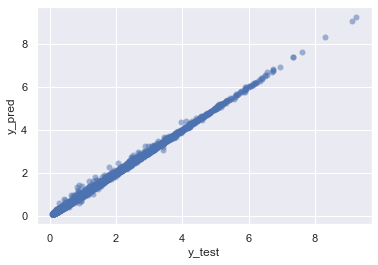

In [51]:
# plot y predicted vs y test
df_test_extract = pd.DataFrame({
    'y_test':y_test[:10000],
    'y_pred':y_pred[:10000]
})

fig,ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df_test_extract,x='y_test',y='y_pred',alpha=0.5,linewidth=.0)

In [39]:
# save
with open('model.pkl','wb') as f:
    pk.dump(reg,f)

### Load and validate model

In [40]:
# load
with open('model.pkl', 'rb') as f:
    trained_model = pk.load(f)

In [57]:
features_col

Index(['Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'],
      dtype='object')

In [86]:
# Get features and labels from validation dataset
X_validation = np.array(df_validation[features_col])

# Make predictions and add it to the validation df
y_valid_pred = trained_model.predict(X_validation)
df_validation['label_prediction'] = y_valid_pred

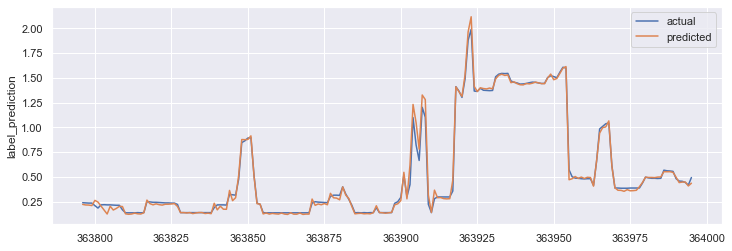

In [92]:
# Extract random TS and plot predictions
length = 200

# select random chunk of validation set
df_validation = df_validation.reset_index(drop=True)
rd_idx = random.randint(0,df_validation.shape[0]-length)
extract = df_validation[rd_idx:rd_idx+length]

fig,ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=extract,x=extract.index, y='label',label='actual')
sns.lineplot(data=extract,x=extract.index, y='label_prediction',label='predicted')